<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# NIRSpec FS Pipeline Notebook

**Authors**: Elena Manjavacas (emanjavacas@stsci.edu), building on the work of Peter Zeidler (zeidler@stsci.edu), Kayli Glidic (kglidic@stsci.edu), and James Muzerolle (muzerol@stsci.edu); NIRSpec branch </br>
**Last Updated**: November 1, 2024 </br>
**Pipeline Version**: 1.15.1 (Build 11.0)

**Purpose**: End-to-end calibration with the James Webb Space Telescope (JWST) pipeline is divided into three main processing stages. This notebook provides a framework for processing generic Near-Infrared Spectrograph (NIRSpec) fixed slit (FS) data through stages 1-3 of the JWST pipeline, including how to use associations for multi-exposure observations and how to interact and work with JWST datamodels. Data is assumed to be organized into three folders: science, background, and associations, as specified in the paths set up below. In most cases, editing cells outside the [Configuration](#1.-Configuration) section is unnecessary unless the standard pipeline processing options need to be modified.

**[Data](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))**: This notebook is set up to use observations of HD1808347 A3V standard star (point source) with the G235M grism obtained by Proposal ID (PID) 1128, Observation 6. The demo data will automatically download unless disabled (i.e., to use local files instead).

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**: This notebook was written for the pipeline version specified above, using the latest CRDS context available in the JWST Calibration Reference Data System (CRDS). Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and CRDS context, taking advantage of bug fixes and algorithm improvements.**
However, if you use a different pipeline version or CRDS context, please read the relevant release notes ([here for the pipeline](https://github.com/spacetelescope/jwst), [here for CRDS](https://jwst-crds.stsci.edu/)) for possibly relevant changes. Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-fs-known-issues#gsc.tab=0) for this build are noted in the notebook. 

**Updates**: This notebook is regularly updated to incorporate the latest pipeline improvements. Find the most up-to-date version of this notebook [here](https://github.com/spacetelescope/jwst-pipeline-notebooks/). 

**Recent Changes**:</br>
November 1, 2024: Converted notebook to follow standard template.

---

## Table of Contents

* [1. Configuration](#1.-Configuration)
* [2. Package Imports](#2.-Package-Imports)
* [3. Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
* [4. Directory Setup](#4.-Directory-Setup)
* [5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)](#5.-Stage-1:-Detector1Pipeline-(calwebb_detector1))
    * [5.1 Configure `Detector1Pipeline`](#5.1-Configure-Detector1Pipeline)
    * [5.2 Run `Detector1Pipeline`](#5.2-Run-Detector1Pipeline)
    * [5.3 Display `Detector1Pipeline` Products](#5.3-Display-Detector1Pipeline-Products)
* [6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)](#5.-Stage-2:-Spec2Pipeline-(calwebb_spec2))
    * [6.1 Configure `Spec2Pipeline`](#6.1-Configure-Spec2Pipeline)
    * [6.2 Create `Spec2Pipeline` ASN Files](#6.2-Create-Spec2Pipeline-ASN-Files)
    * [6.3 Run `Spec2Pipeline`](#6.3-Run-Spec2Pipeline)
    * [6.4 Display `Spec2Pipeline` Products](#6.4-Display-Spec2Pipeline-Products)
* [7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)](#5.-Stage-3:-Spec3Pipeline-(calwebb_spec3))
    * [7.1 Configure `Spec3Pipeline`](#7.1-Configure-Spec3Pipeline)
    * [7.2 Create `Spec3Pipeline` ASN Files](#7.2-Create-Spec3Pipeline-ASN-Files)
    * [7.3 Run `Spec3Pipeline`](#7.3-Run-Spec3Pipeline)
    * [7.4 Display `Spec3Pipeline` Products](#7.4-Display-Spec3Pipeline-Products)
* [8. Modifying the EXTRACT1D Reference File (as needed)](#8.-Modifying-the-EXTRACT1D-Reference-File-(as-needed))


---

## 1. Configuration

Set the basic parameters to configure the notebook. These parameters determine what data gets used, where data is located (if already on disk), pipeline modules run on the data, and the type of background subtraction (if any). The list of parameters includes:

* `demo_mode`:
    * `True`: Downloads example data from the [Barbara A. Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) and processes it through the pipeline. All processing will occur in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.
    * `False`: Process your own downloaded data; provide its location.
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.
    * `bg_dir`: Directory where background observation data is stored.
* **[Backgroud subtraction methods](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_subtraction/main.html#spectroscopic-modes:~:text=the%20calwebb_image3%20pipeline.-,Spectroscopic%20Modes,%EF%83%81,-Spectroscopic%20observations%20allow)** (`True` = run, `False` = skip):
    * `master_bg`: Apply master-background subtraction in `calwebb_spec3`?
    * `pixel_bg`: Apply pixel-to-pixel background subtraction in `calwebb_spec2`?
* **Compare with MAST products** (`compare_mast`): Compare latest reductions to data products from the MAST archive?


In [1]:
import os  # Basic import necessary for configuration.

# Hide all log and warning messages?
import warnings
import logging
logging.disable(logging.ERROR)  # Comment out for log output.
warnings.simplefilter("ignore", RuntimeWarning)

<div class="alert alert-block alert-warning">
    
Note that `demo_mode` must be set appropriately below.
</div>

In [2]:
# Set parameters for demo_mode, data mode directories, and processing steps.

# -----------------------------Demo Mode---------------------------------

demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------

# If demo_mode = False, look for user data in these paths.
else:
    # Set directory paths for processing specific data; these will need
    # to be changed to your local directory setup (below are given as
    # examples).
    basedir = os.getcwd()+'/'

    # Point to where science observation data are.
    # Assumes uncalibrated data in sci_dir/uncal/ and results in stage1,
    # stage2, stage3 directories.
    sci_dir = os.path.join(basedir, 'fs_data_01328/Obs036/')

    # Point to where background observation data are.
    # Assumes uncalibrated data in bg_dir/uncal/ and results in stage1,
    # stage2, stage3 directories.
    # bg_dir = os.path.join(basedir, 'fs_data_01328/Obs036/')
    bg_dir = '' # If no background observation, use an empty string.

    # Point to where stage 2/3 association files are.
    # We will modify/check the paths to files in a later section.
    asn_dir = os.path.join(basedir, 'asn/')

# --------------------------Set Processing Steps--------------------------

# How should background subtraction using any dedicated backgrounds be done?
# If none are selected, data will not be background subtracted.
master_bg = False  # Master-background subtraction in spec3.
pixel_bg = True  # Pixel-based background subtraction in spec2.

# Download and compare products in MAST?
compare_mast = True

Running in demonstration mode using online example data!


---

### Set CRDS Context and Server

Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline.

If the local CRDS cache directory has not been set, it will automatically be created in the home directory.

In [3]:
# ------------------------ Set CRDS context and paths ------------------------

# Set CRDS context (if overriding to use a specific version of reference
# files; leave commented out to use latest reference files by default).
# %env CRDS_CONTEXT  jwst_1146.pmap

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /Users/kglidic/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


[Link to Table of Contents](#Table-of-Contents)

---

## 2. Package Imports


In [4]:
# Use the entire available screen width for this notebook.
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# ----------------------General Imports----------------------

import time
import copy
import glob
import json
import requests
import itertools
import numpy as np
from pathlib import Path

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.io import fits
from astropy.stats import sigma_clip
from astroquery.mast import Observations
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from IPython.display import JSON
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found here: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) • 
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) • 
[Github](https://github.com/spacetelescope/jwst)

</div> 

In [6]:
# ----------------------JWST Calibration Pipeline Imports----------------------
# Import the base JWST and calibration reference data packages.
import jwst
import crds
from crds.client import api
from stpipe import crds_client

# JWST pipelines (each encompassing many steps).
from jwst.pipeline import Detector1Pipeline  # calwebb_detector1
from jwst.pipeline import Spec2Pipeline  # calwebb_spec2
from jwst.pipeline import Spec3Pipeline  # calwebb_spec3

# JWST pipeline utilities.
from jwst import datamodels  # JWST datamodels.

# Echo pipeline version and CRDS context in use.
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print("Using CRDS Context = {}".format(crds.get_context_name('jwst')))

JWST Calibration Pipeline Version = 1.15.1
Using CRDS Context = jwst_1293.pmap


---

### Define Convience Functions

In [7]:
def get_jwst_file(name,
                  mast_api_token=None,
                  save_directory=".",
                  redownload=False):
    """
    Retrieve a JWST data file from MAST archive and save it to a specified directory.

    Parameters
    ----------
    name : str
        File name.
    mast_api_token : str
        MAST authorization token. Get your MAST Token Here: https://auth.mast.stsci.edu/token.
    save_directory : str
        Save directory path.
    redownload : bool
        Redownload the data even if it exsits already?

    Returns
    -------
    file_path : str
        Path to newly saved file.
    """
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    headers = {"Authorization": f"token {mast_api_token}"} if mast_api_token else {}
    file_path = os.path.join(save_directory, name)

    # Check if the file already exists in the save directory.
    if os.path.exists(file_path) and not redownload:
        print(f"The file {name} already exists in the directory. Skipping download.")
        return file_path

    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()

    with open(file_path, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

    return file_path

In [8]:
def update_asn_paths(asn_files,
                     exclude_dirs=[]):
    """
    Update the expname field in an ASN file with its absolute path.

    The absolute path is determined by locating matching files in the
    current directory while excluding any files found in the specified
    excluded directories. Absolute paths ensure that the pipeline correctly
    locates the files, regardless of the ASN file's location.

    Parameters
    ----------
    asn_files : list of str
        List of ASN files to update.
    exclude_dirs : list of str, optional
        List of directories to exclude in the search.

    Returns
    -------
    None.
    """

    # Ensure asn_files is a list.
    asn_files = [asn_files] if isinstance(asn_files, str) else asn_files

    for asn in asn_files:
        data = json.load(open(asn, 'r'))

        update = False

        # Loop through each product and its members.
        for product in data['products']:
            for member in product['members']:
                search_pattern = f"**/{member['expname']}"
                filtered_files = [f for f in glob.glob(os.path.join(os.getcwd(),
                                  search_pattern), recursive=True) if not
                                  any(f.startswith(exc) for exc in exclude_dirs)]
                if filtered_files:
                    member['expname'] = filtered_files[0]
                    update = True
        if update:
            with open(asn, 'w') as json_file:
                json.dump(data, json_file, indent=4)
                basn = os.path.basename(asn)
                print(f"{basn} 'expname' paths have been updated to absolute paths!")
        else:
            print(f"{basn} 'expname' paths NOT updated! Paths may be absolute.")

In [9]:
def display_rate(rate_files,
                 slits_models=[],
                 integration=None,
                 extname='data',
                 cmap='viridis',
                 bad_color=(1,0.7,0.7),
                 vmin=None,
                 vmax=None,
                 scale='asinh',
                 aspect='auto',
                 show_colorbar=True,
                 title_prefix=None,
                 title_path=False,
                 save_plot=False):
    """
    Display countrate images.

    Parameters
    ----------
    rate_files : list of str
        A list of file paths to the rate files to be displayed.
    slits_models : list of str, optional
        A list of file paths to the corresponding slit models (CAL, S2D).
        If provided, slit cutouts will be overlaid on the images.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used.
    extname : str, optional
        The name of the data extension to extract from
        the rate files ('data', 'dq', etc.). Default is 'data'.
    cmap : str, optional
        Colormap to use for displaying the image. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for bad pixels. Default is light red (1, 0.7, 0.7).
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    show_colorbar : bool, optional
        Whether to display a colorbar. Default is True.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    save_plot : bool, optional
        If True, saves the plot as a PNG file. Default is False.
    """

    # Ensure rate_files and slits_models is a list.
    rate_files = [rate_files] if isinstance(rate_files, str) else rate_files
    slits_models = [slits_models] if isinstance(slits_models, str) else slits_models

    # Set up figures.
    fig, axes = plt.subplots(len(rate_files), 1, figsize=(12, 12*len(rate_files)),
                             sharex=True, height_ratios=[1] * len(rate_files))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)  # Adjust hspace and wspace as needed.
    axes = [axes] if len(rate_files) == 1 else axes
    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)

    # Loop through and plot the data products.
    for i, (rate, cal) in enumerate(itertools.zip_longest(rate_files,
                                                          slits_models,
                                                          fillvalue=None)):

        model = datamodels.open(rate)  # Open files as JWST datamodels.
        slits_model = datamodels.open(cal) if cal else None

        # Extract data.
        data_2d = getattr(model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(
                    f"Invalid integration value: "
                    f" '{integration}' for 3D data."
                )

        # Plot data.
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        if scale == 'log':
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=LogStretch())
        elif scale == 'linear':
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=LinearStretch())
        elif scale == 'asinh':
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=AsinhStretch())
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)
        im = axes[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')

        # Draw slits and label source ids.
        # slits_model can be s2d/cal from spec2 - contains slit models for all sources.
        if slits_model:
            slit_patches = []
            for slit in slits_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart),
                                       slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                y = slit.ystart + slit.ysize / 2
                x = slit.xstart if 'nrs1' in rate else slit.xstart + slit.xsize
                ha = 'right' if 'nrs1' in rate else 'left'
                plt.text(x, y, slit.source_id, color='w', ha=ha, va='center',
                         fontsize=7, path_effects=[], weight='bold')
            axes[i].add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

        # Add colorbar if specified.
        if show_colorbar:
            plt.subplots_adjust(left=0.05, right=0.85)
            units = model.meta.bunit_data
            cbar_ax = fig.add_axes([axes[i].get_position().x1 + 0.02,
                                    axes[i].get_position().y0, 0.02,
                                    axes[i].get_position().height])
            cbar = fig.colorbar(im, cax=cbar_ax)
            cbar.set_label(units, fontsize=12)  # Set the font size.

        # Construct title.
        filename = model.meta.filename
        title = (f"{title_prefix + ' ' if title_prefix else ''}"
                 f"{filename if title_path else os.path.basename(filename)}")

        if integration is not None:
            title = title.replace('rateints', f'rateints[{integration}]')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Pixel Column", fontsize=12)
        axes[i].set_ylabel("Pixel Row", fontsize=12)

        if save_plot:
            save_plot = rate.replace('fits', 'png')
            if integration:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
            fig.savefig(save_plot, dpi=200)

        fig.show()

In [10]:
def display_spectra(data_products,
                    compare_x1d=None,
                    compare_mast=None,
                    integration=None,
                    extname='data',
                    source_id=1,
                    source_type=None,
                    expand_wavelength_gap=True,
                    plot_resample=True,
                    plot_errors=False,
                    cmap='viridis',
                    bad_color=(1,0.7,0.7),
                    aspect='auto',
                    vmin=None,
                    vmax=None,
                    scale='asinh',
                    title_prefix=None,
                    title_path=False,
                    y_limits=None,
                    is_stage3=False):

    """
    Display 2D and 1D spectra for given data products.

    Parameters
    ----------
    data_products : list of str
        A list of file paths to the data products (e.g., CAL, S2D, X1D files).
    compare_x1d : list of str, optional
        A list of file paths to 1D spectra for comparison.
    compare_mast : list of str, optional
        A list of file paths to MAST 1D spectra for comparison.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used.
     extname : str, optional
        The name of the data extension to extract
        from the rate files ('data', 'dq', etc.). Default is 'data'.
    source_id : int or str, optional
        Identifier for the source/slit to be displayed. Default is 1.
    source_type : str, optional
        Type of source ('POINT' or 'EXTENDED'). If None, it is inferred from the data.
    expand_wavelength_gap : bool, optional
        If True, expands gaps in the wavelength data for better visualization.
        Default is True.
    plot_resample : bool, optional
        If True, plots resampled (S2D) data products;
        otherwise, plots calibrated (CAL) data. Default is True.
    plot_errors : bool, optional
        If True, plots the error bands for the 1D spectra. Default is False.
    cmap : str, optional
        Colormap to use for displaying the images. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for bad pixels. Default is light red (1, 0.7, 0.7).
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    y_limits : tuple of float, optional
        Limits for the y-axis of the 1D spectrum plot.
        If None, limits are determined from the data.
    is_stage3 : bool, optional
        Plot stage 3 products? Default is False.

    Returns
    -------
    None.
    """

    # -----------------------Check and sort input lists-----------------------

    data_products = [data_products] if isinstance(data_products, str) else data_products
    compare_x1d = [compare_x1d] if isinstance(compare_x1d, str) else compare_x1d
    compare_mast = [compare_mast] if isinstance(compare_mast, str) else compare_mast

    # Plot stage 3 products?
    if is_stage3:

        # Stage 3 products should include the source_id in the filename.
        # Sort based on filename rather than open all.
        def filter_prod(products, source_id):
            """Filter products based on the source_id."""
            return [f for f in products if source_id.lower() in f and
                    ('FXD_SLIT' not in fits.getheader(f, ext=0) or
                     fits.getheader(f, ext=0)['FXD_SLIT'].lower() == source_id.lower())]

        data_products = filter_prod(data_products, source_id)
        compare_x1d = filter_prod(compare_x1d, source_id) if compare_x1d else None
        compare_mast = filter_prod(compare_mast, source_id) if compare_mast else None

    file_types = {ftype: [f for f in data_products if ftype in f]
                  for ftype in ["cal", "s2d", "x1d"]}
    products = sorted(file_types['s2d']) if plot_resample else sorted(file_types['cal'])
    if not products:
        raise ValueError("No valid data products found for plotting.")

    # -----------------------------Set up figures-----------------------------

    total_plots = len(products) + bool(file_types['x1d'])
    height_ratios = [1] * len(products) + ([3] if bool(file_types['x1d']) else [])
    fig, axes = plt.subplots(total_plots, 1, figsize=(15, 5*total_plots), sharex=False,
                height_ratios=height_ratios)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax2d, ax1d = (axes[:-1], axes[-1]) if bool(file_types['x1d']) else (axes, None)

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)
    colors = plt.get_cmap('tab10').colors
    color_cycle = itertools.cycle(colors)

    # --------------------------------------------------------------------

    for i, product in enumerate(products):
        model = datamodels.open(product)  # Open files as JWST datamodels.

        # Extract the correct 2D source spectrum if there are multiple.
        slit_model = model
        if 'slits' in model:
            try:
                slit_model = next((slit for slit in model.slits if
                                   getattr(slit, 'name', None) == source_id), None)
                if not slit_model:
                    slit_model = next((slit for slit in model.slits if
                                       slit.source_id == source_id), None)
            except ValueError:
                print(f"Error: source_id '{source_id}' is invalid.")
                print(f"Available source_ids: "
                     f"{[slit.source_id for slit in model.slits][:5]}")
                break

        # Check if 'fixed_slit' exists, otherwise fall back to 'slitlet_id'
        slit_name = (
            f"SLIT: {getattr(slit_model, 'name', None) or slit_model.slitlet_id}, "
            f"SOURCE: {getattr(slit_model, 'source_id', '')}"
        )

        # Extract 2D data.
        data_2d = getattr(slit_model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration value: "
                                 f"'{integration}' for 3D data.")

        # ---------------------Construct legends and annotations---------------------

        ffilter = slit_model.meta.instrument.filter
        grating = slit_model.meta.instrument.grating
        label_2d = f'{grating}/{ffilter}'
        if model.meta.visit.tsovisit:
            label_2d = f'Segment {model.meta.exposure.segment_number} ({label_2d})'
        elif not model.meta.cal_step.outlier_detection:
            label_2d = f'Dither/Nod {model.meta.dither.position_number} ({label_2d})'
        ax2d[i].annotate(label_2d, xy=(1, 1), xycoords='axes fraction',
                         xytext=(-10, -10), textcoords='offset points',
                         bbox=dict(boxstyle="round,pad=0.3", edgecolor='white',
                                   facecolor='white', alpha=0.8),
                         fontsize=12, ha='right', va='top')

        # ----------------Convert from pixels to wavelength (x-axis)----------------

        wcsobj = slit_model.meta.wcs  # Obtaining the WCS object from the meta data.
        y, x = np.mgrid[:slit_model.data.shape[0], :slit_model.data.shape[1]]
        # Coordinate transform from detector space (pixels) to sky (RA, DEC).
        det2sky = wcsobj.get_transform('detector','world')
        ra, dec, s2dwave = det2sky(x, y)  # RA/Dec, wavelength (microns) for each pixel.
        s2dwaves = s2dwave[0, :] # Single row since this is the rectified spectrum.
        x_arr = np.arange(0, slit_model.data.shape[1], int(len(slit_model.data[1]) / 4))
        wav = np.round(s2dwaves[x_arr], 2)  # Populating the wavelength array.
        ax2d[i].set_xticks(x_arr, wav)

        # xticks = np.arange(np.ceil(wave_1d[0]), wave_1d[-1], 0.2)
        # xtick_pos = np.interp(xticks, wave_1d, np.arange(num_waves))
        # ax1d.set_xticks(xtick_pos)
        # ax1d.set_xticklabels([f'{xtick:.1f}' for xtick in xticks])

        # -----------------------Plot 1D Spectra-----------------------

        # Plot 1D spectra and comparison if provided.
        for products, prefix in [(sorted(file_types['x1d']),  f'{title_prefix} '),
                                 (compare_x1d, 'RE-EXTRACTION '), (compare_mast, 'MAST ')]:
            print(products)
            if products:

                model_1d = datamodels.open(products[i])

                spec = next((s for s in model_1d.spec if getattr(s, 'name', None) == source_id), None)
                if not spec:
                    spec = next((s for s in model_1d.spec if s.source_id == source_id), None)

                if spec:
                    source_type = source_type if source_type else slit_model.source_type
                    wave_1d = spec.spec_table.WAVELENGTH
                    flux_1d = (spec.spec_table.FLUX if source_type == 'POINT'
                               else spec.spec_table.SURF_BRIGHT)
                    errs_1d = (spec.spec_table.FLUX_ERROR if source_type == 'POINT'
                               else spec.spec_table.SB_ERROR)

                    if expand_wavelength_gap:
                        dx1d_wave = wave_1d[1:] - wave_1d[:-1]
                        igap = np.argmax(dx1d_wave)
                        dx_replace = (dx1d_wave[igap-1] + dx1d_wave[igap+1]) / 2.
                        num_fill = int(np.round(np.max(dx1d_wave) / dx_replace))

                        if num_fill > 1:
                            print("Expanding wavelength gap %.2f -- %.2f microns" %
                                  (wave_1d[igap], wave_1d[igap+1]))
                            wave_fill = np.mgrid[
                                    wave_1d[igap]:wave_1d[igap + 1]:(num_fill + 1) * 1j]
                            wave_1d = np.concatenate([wave_1d[:igap+1],
                                                      wave_fill[1:-1],
                                                      wave_1d[igap+1:]])

                            if prefix !='RE-EXTRACTION ':
                                num_rows, num_waves = data_2d.shape
                                fill_2d = np.zeros(shape=(num_rows, num_fill-1))*np.nan
                                data_2d = np.concatenate([data_2d[:, :igap+1],
                                                          fill_2d, data_2d[:, igap+1:]],
                                                          axis=1)

                            fill_1d = np.zeros(shape=(num_fill-1)) * np.nan
                            flux_1d = np.concatenate([flux_1d[:igap+1],
                                                      fill_1d, flux_1d[igap+1:]])
                            errs_1d = np.concatenate([errs_1d[:igap+1],
                                                      fill_1d, errs_1d[igap+1:]])
                    else:
                        num_fill=0
                    num_waves = len(wave_1d)

                    label_1d = (f'{slit_model.meta.instrument.detector} '
                                f'({slit_model.meta.instrument.grating}/{slit_model.meta.instrument.filter})')
                    if model.meta.visit.tsovisit:
                        label_1d = (f'{prefix}Segment '
                                    f'{model_1d.meta.exposure.segment_number} '
                                    f'{label_1d}')
                    elif not model.meta.cal_step.outlier_detection:
                        label_1d = (f'{prefix}Dither/Nod '
                                    f'{model_1d.meta.dither.position_number} '
                                    f'{label_1d}')
                    else:
                        label_1d = f'{prefix}{label_1d}'

                    color = next(color_cycle)

                    ax1d.step(wave_1d, flux_1d, lw=1, label=label_1d, color=color)
                    if plot_errors:
                        ax1d.fill_between(np.arange(num_waves), flux_1d - errs_1d,
                                          flux_1d + errs_1d, color='grey', alpha=0.3)
                    ax1d.legend(fontsize=12)

                # ----------------Add extraction box----------------

                if spec:

                    ystart, ystop, xstart, xstop = (spec.extraction_ystart-1,
                                                    spec.extraction_ystop-1,
                                                    spec.extraction_xstart-1,
                                                    spec.extraction_xstop-1)
                    extract_width = ystop - ystart + 1
                    box = Rectangle((xstart, ystart), xstop - xstart+num_fill,
                                    extract_width, fc='None', ec=color,
                                    lw=2, label=prefix)
                    ax2d[i].add_patch(box)

        # --------------- Plot 2D spectra ---------------

        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        if scale == 'log':
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=LogStretch())
        elif scale == 'linear':
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=LinearStretch())
        elif scale == 'asinh':
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=AsinhStretch())
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)
        im = ax2d[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')

        # Add colorbar if specified.
        plt.subplots_adjust(left=0.05, right=0.85)
        units = slit_model.meta.bunit_data
        cbar_ax = fig.add_axes([ax2d[i].get_position().x1 + 0.02,
                                    ax2d[i].get_position().y0, 0.02,
                                    ax2d[i].get_position().height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(units, fontsize=12)  # Set the font size.


        # ------------------ Construct titles for plots ------------------

        title_2d = (f"{title_prefix + ' ' if title_prefix else ''}"
                    f"{model.meta.filename} | {slit_name}")
        if integration:
            title_2d = title_2d.replace('.fits', f'[{integration}].fits')
        ax2d[i].set_title(title_2d, fontsize=14)
        if not bool(file_types['x1d']):
            ax2d[i].set_xlabel("Wavelength (μm)", fontsize=12)
        ax2d[i].set_ylabel("Pixel Row", fontsize=12)
        ax2d[i].legend(fontsize=12)

        ax1d.set_title(f"{title_prefix + ' ' if title_prefix else ''}"
                       f"Extracted 1D Spectra | {slit_name}", fontsize=14)
        ax1d.set_ylabel("Flux (Jy)" if source_type == 'POINT'
                        else "Surface Brightness (MJy/sr)", fontsize=12)
        ax1d.set_xlabel("Wavelength (μm)", fontsize=12)

        ax1d.set_ylim(y_limits if y_limits else (np.nanpercentile(flux_1d, 1),
                                                 np.nanpercentile(flux_1d, 99.5)))

[Link to Table of Contents](#Table-of-Contents)

---

## 3. Demo Mode Setup (ignore if not using demo data)

<div class="alert alert-block alert-info">

To download data from MAST, you may need to input an authorization token. Get your MAST token here: https://auth.mast.stsci.edu/token. Additionally, follow [`astroquery` installation procedures](https://astroquery.readthedocs.io/en/latest/index.html#) to properly run these cells. 
    
</div> 


If running in demonstration mode, set up the program information to retrieve the uncalibrated data (`_uncal.fits`) automatically from MAST using `astroquery`. MAST provides flexibility by allowing searches based on proposal ID and observation ID, rather than relying solely on filenames. More information about the JWST file naming conventions can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).


The FS demo data in this notebook is from the [NIRSpec calibration program 1128](https://www.stsci.edu/jwst/science-execution/program-information?id=1128) and features observations of HD1808347 (point source) using the G235M grism. The program setup is briefly summarized in the table below.


| Demo Target: HD1808347 A3V Standard Star |       |   | 
|:-----------:|:-------:|:---:|
| PROGRAM | 01128 | Program number | 
| OBSERVTN | 006 | Observation number | 
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-fixed-slits-spectroscopy#gsc.tab=0:~:text=%C2%A0Table%202.%20NIRSpec%20A%20fixed%20slit%C2%A0instrument%20configurations%2C%20resolutions%2C%20and%20wavelength%20ranges) | G235M/F170LP | λ: 1.66–3.17 μm (a medium resolution, R ~ 1000) |
| SUBARRAY | SUBS200A1 | Subarray used | 
| NINTS | 2 | Number of integrations in exposure |           
| NGROUPS | 30 | Number of groups in integration |
| DURATION | 96.637 [s] | Total duration of one exposure |   
| READPATT | NRSRAPID | Readout pattern | 
| PATTTYPE | 3-POINT-NOD | Primary dither pattern type |  
| NUMDTHPT | 3 |  Total number of points in pattern |                           
| SRCTYAPT | POINT | Source type selected in APT |

> **Note:** The presence of a physical gap between detectors affects high-resolution FS observations because the spectra are long enough to span both NIRSpec detectors. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-fs-operations/nirspec-fs-wavelength-ranges-and-gaps#gsc.tab=0)



The demo dataset consists of three `_uncal.fits` files, each approximately 15 MB in size.

In [11]:
# Set up the program information for demo mode.
if demo_mode:

    print('Running in demonstration mode. Example data will be downloaded '
          'from MAST!')

    # NOTE:
    # The data in this notebook is public and does not require a token.
    # For other data sets, you may need to provide a token.
    # Observations.login(token=None)

    # Program and observation information.
    program = "01128"
    sci_observtn = "006"
    bg_observtn = None
    filters = ["F170LP;G235M"]

    # Define the base directory and observation directories.
    basedir = os.path.join('.', f'fs_data_{program}')
    sci_dir = os.path.join(basedir, f'Obs{sci_observtn}')
    bg_dir = os.path.join(basedir, f'Obs{bg_observtn}') if bg_observtn else ''
    asn_dir = os.path.join(basedir, 'asn/')

    uncal_dir = os.path.join(sci_dir, 'uncal/')
    uncal_bgdir = os.path.join(bg_dir, 'uncal/') if bg_observtn else ''

    # Ensure output directories exist.
    os.makedirs(uncal_dir, exist_ok=True)
    os.makedirs(asn_dir, exist_ok=True)
    if bg_observtn:
        os.makedirs(uncal_bgdir, exist_ok=True)

Running in demonstration mode. Example data will be downloaded from MAST!


In [12]:
# Obtain a list of observation IDs for the specified demo program.

if demo_mode:

    # Science data.
    sci_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/SLIT'],
                                                   provenance_name=["CALJWST"],
                                                   obs_id=[f'*{program}*{sci_observtn}*'])
    # Background data.
    bg_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/SLIT'],
                                                  provenance_name=["CALJWST"],
                                                  obs_id=[f'*{program}*{bg_observtn}*'])

In [13]:
# Convert visits into a list of uncalibrated data ans ASN files.

if demo_mode:

    file_criteria = {'filters': filters,
                     'productSubGroupDescription': 'UNCAL',
                     'calib_level': [1]}
    asn_criteria = {'filters': filters,
                    'productSubGroupDescription':
                    'ASN', 'calib_level': [2, 3]}

    # Initialize lists for science, background, and ASN files.
    sci_files_to_download = []
    bg_files_to_download = []
    asn_files_to_download = []

    # Identify uncalibrated science files associated with each visit.
    for exposure in sci_obs_id_table:
        sci_products = Observations.get_product_list(exposure)
        asn_files_to_download.extend(
            Observations.filter_products(sci_products, **asn_criteria)['dataURI'])

        # Only keep science files with full data;
        # not smaller files (confirmation images with fewer groups).
        sci_products = sci_products[
            sci_products['size'] > np.nanmean(sci_products['size'])]
        sci_files_to_download.extend(
            Observations.filter_products(sci_products, **file_criteria)['dataURI'])

    # Identify uncalibrated background files associated with each visit.
    for exposure in bg_obs_id_table:
        bg_products = Observations.get_product_list(exposure)

        # Only keep background files with full data;
        # not smaller files (confirmation images with fewer groups).
        bg_products = bg_products[bg_products['size'] > np.nanmean(bg_products['size'])]
        bg_files_to_download.extend(
            Observations.filter_products(bg_products, **file_criteria)['dataURI'])

    # Filter out other observations and remove duplicates.
    sci_files_to_download = np.unique(
        [f for f in sci_files_to_download if f'jw{program}{sci_observtn}' in f])
    bg_files_to_download = np.unique(
        [f for f in bg_files_to_download if f'jw{program}{bg_observtn}' in f])
    asn_files_to_download = np.unique(
        [f for f in asn_files_to_download
         if f'-o{sci_observtn}_' in f or f'-c?{sci_observtn}' in f])

    print(f"Science files selected for downloading: {len(sci_files_to_download)}")
    print(f"Background files selected for downloading: {len(bg_files_to_download)}")
    print(f"ASN files selected for downloading: {len(asn_files_to_download)}")


Science files selected for downloading: 6
Background files selected for downloading: 0
ASN files selected for downloading: 4


In [14]:
# Download data and place them into the appropriate directories.
if demo_mode:

    for filename in sci_files_to_download:
        sci_manifest = Observations.download_file(
            filename, local_path=os.path.join(uncal_dir, Path(filename).name))
    for filename in bg_files_to_download:
        bg_manifest = Observations.download_file(
            filename, local_path=os.path.join(uncal_bgdir, Path(filename).name))
    for filename in asn_files_to_download:
        asn_manifest = Observations.download_file(
            filename, local_path=os.path.join(asn_dir, Path(filename).name))

<div class="alert alert-block alert-warning">

**Warning**: If this notebook is halted during this step, the downloaded file may be incomplete, and cause crashes later on!
</div>

[Link to Table of Contents](#Table-of-Contents)

---

## 4. Directory Setup
Set up detailed paths to input/output stages here.

In [15]:
# Define output subdirectories to keep science data products organized.
uncal_dir = os.path.join(sci_dir, 'uncal/')  # Uncalibrated pipeline inputs.
det1_dir = os.path.join(sci_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_dir = os.path.join(sci_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.
spec3_dir = os.path.join(sci_dir, 'stage3/')  # calwebb_spec3 pipeline outputs.

# Output subdirectories to keep background data products organized.
uncal_bgdir = os.path.join(bg_dir, 'uncal/')  # Uncalibrated pipeline inputs.
det1_bgdir = os.path.join(bg_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_bgdir = os.path.join(bg_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.

mast_products_dir = os.path.join(basedir, 'mast_products/')  # MAST products.

# Create output subdirectories to keep data products organized.
os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(spec3_dir, exist_ok=True)

if bg_dir:
    os.makedirs(det1_bgdir, exist_ok=True)
    os.makedirs(spec2_bgdir, exist_ok=True)

if compare_mast:
    os.makedirs(mast_products_dir, exist_ok=True)

[Link to Table of Contents](#top)

---

## 5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)

In this section, we process the data through the `calwebb_detector1` pipeline to create Stage 1 data products.

* **Input**: Raw exposure (`_uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
* **Output**: Uncalibrated countrate (slope) image in units of DN/s:
    * `_rate.fits`: A single countrate image averaged over multiple integrations (if available).
    * `_rateints.fits`: Countrate images for each integration, saved in multiple extensions.

The `Detector1Pipeline` applies basic detector-level corrections on a group-by-group basis, followed by ramp fitting for all exposure types, commonly referred to as "ramps-to-slopes" processing. 

---

### 5.1 Configure `Detector1Pipeline`

The `Detector1Pipeline` has the following steps available for NIRSpec FS:

> * `group_scale` : Rescales pixel values to correct for improper onboard frame averaging.
> * `dq_init` : Initializes the data quality (DQ) flags for the input data.
> * `saturation` : Flags pixels at or below the A/D floor or above the saturation threshold.
> * `superbias` : Subtracts the superbias reference file from the input data.
> * `refpix` : Use reference pixels to correct bias drifts.
> * `linearity` : Applies a correction for non-linear detector response.   
> * `dark_current` : Subtracts the dark current reference file from the input data.
> * `jump` : Performs CR/jump detection on each ramp integration within an exposure.
> * `ramp_fit` : Determines the mean count rate (counts per second) for each pixel by performing a linear fit to the input data.
> * `gain_scale` : Corrects pixel values for non-standard gain settings, primarily in NIRSpec subarray data.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

Below, we set up a dictionary that defines how the `Detector1Pipeline` should be configured for FS data. 

<div class="alert alert-warning">
  To override specific steps and reference files, use the examples below.
</div>


In [16]:
# Set up a dictionary to define how the Detector1 pipeline should be configured.

# Boilerplate dictionary setup.
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['superbias'], det1dict['refpix'] = {}, {}
det1dict['linearity'], det1dict['dark_current'] = {}, {}
det1dict['jump'], det1dict['ramp_fit'], det1dict['gain_scale']= {}, {}, {}

# Overrides for whether or not certain steps should be skipped (example).
det1dict['linearity']['skip'] = False  # This is the default.

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
# det1dict['dq_init']['override_mask'] = 'myfile.fits' # Bad pixel mask
# det1dict['superbias']['override_superbias'] = 'myfile.fits' # Bias subtraction
# det1dict['dark_current']['override_dark'] = 'myfile.fits' # Dark current subtraction

# Turn on multi-core processing (off by default).
# Choose what fraction of cores to use (quarter, half, or all).
det1dict['jump']['maximum_cores'] = 'half'
# det1dict['ramp_fit']['maximum_cores'] = 'half'

# Turn on detection of cosmic ray snowballs (on by default).
det1dict['jump']['expand_large_events'] = True
# Works better for NIRSpec to mask the entire snowball region (default 2).
det1dict['jump']['expand_factor'] = 3

# Suppress computations for saturated ramps
# with only one good (unsaturated) sample (default True)?
det1dict['ramp_fit']['suppress_one_group'] = False

<div class="alert alert-info">
    
Many exposures are affected by artifacts known as [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts#gsc.tab=0) caused by large cosmic ray events. These artifacts are particularly significant in deep exposures with long integration times, with an estimated rate of one snowball per detector (FULL FRAME) per 20 seconds. To expand the number of pixels flagged as jumps around large cosmic ray events, set `expand_large_events` to True. An `expand_factor` of 3 works well for NIRSpec observations to cover most snowballs.
</div>

---

### 5.2 Run `Detector1Pipeline`

Run the science files and, if available, any background files through the `calwebb_detector1` pipeline using the `.call()` method. We use `.call()` instead of `.run()` to ensure that the latest default parameters from CRDS are applied ([ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html)).

This stage takes approximately 2 minutes to process three `_uncal.fits` files from the demo data.

In [17]:
# Final list of UNCAL files ready for Stage 1 processing.
uncal_sci = sorted(glob.glob(uncal_dir + '*uncal.fits'))
uncal_bg = sorted(glob.glob(uncal_bgdir + '*uncal.fits'))

print(f"Science UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_sci))
print(f"Background UNCAL Files:\n{'-'*20}\n" + "\n".join(uncal_bg))

Science UNCAL Files:
--------------------
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00001_nrs1_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00001_nrs2_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00002_nrs1_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00002_nrs2_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00003_nrs1_uncal.fits
./fs_data_01128/Obs006/uncal/jw01128006001_0310c_00003_nrs2_uncal.fits
Background UNCAL Files:
--------------------



In [18]:
# Run Stage 1 pipeline using the custom det1dict dictionary.

start = time.time()

# Science files.
for uncal_file in sorted(glob.glob(uncal_dir + '*uncal.fits')):
    print(f"Applying Stage 1 Corrections & Calibrations to: "
          f"{os.path.basename(uncal_file)}")
    det1_result = Detector1Pipeline.call(uncal_file, save_results=True,
                                         steps=det1dict, output_dir=det1_dir)

# Background files.
for uncal_file in sorted(glob.glob(uncal_bgdir + '*uncal.fits')):
    print(f"Applying Stage 1 Corrections & Calibrations to: "
          f"{os.path.basename(uncal_file)}")
    det1bg_result = Detector1Pipeline.call(uncal_file, save_results=True,
                                           steps=det1dict, output_dir=det1_bgdir)

print(f"\nRun time: {round((time.time()-start)/60.0, 1)} min")
print("Hurray ... Stage 1 has been completed!\n")

Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00001_nrs1_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00001_nrs2_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00002_nrs1_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00002_nrs2_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00003_nrs1_uncal.fits
Applying Stage 1 Corrections & Calibrations to: jw01128006001_0310c_00003_nrs2_uncal.fits

Run time: 0.8 min
Hurray ... Stage 1 has been completed!



In [19]:
# Print output result details:
# det1_result.__dict__  # View entire contents.
# det1_result.meta.filename
# det1_result.data.shape

---

### 5.3 Display `Detector1Pipeline` Products

Inspect the Stage 1 slope products. If `compare_mast` is enabled, an additional plot will compare the reprocessed results with MAST products, which were processed using the default pipeline parameters. Reprocessing with a newer pipeline version may result in noticeable improvements in data quality.

In [20]:
# Final list of RATE[INTS] files ready for Stage 2 processing.
rate_sci = sorted(glob.glob(det1_dir+'*_rate.fits'))
rate_bg = sorted(glob.glob(det1_bgdir+'*_rate.fits'))

print(f"SCIENCE | RATE[INTS] Files:\n{'-'*20}\n" + "\n".join(rate_sci))
print(f"BACKGROUND | RATE[INTS] Files:\n{'-'*20}\n" + "\n".join(rate_bg))

SCIENCE | RATE[INTS] Files:
--------------------
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs1_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00001_nrs2_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs1_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00002_nrs2_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs1_rate.fits
./fs_data_01128/Obs006/stage1/jw01128006001_0310c_00003_nrs2_rate.fits
BACKGROUND | RATE[INTS] Files:
--------------------



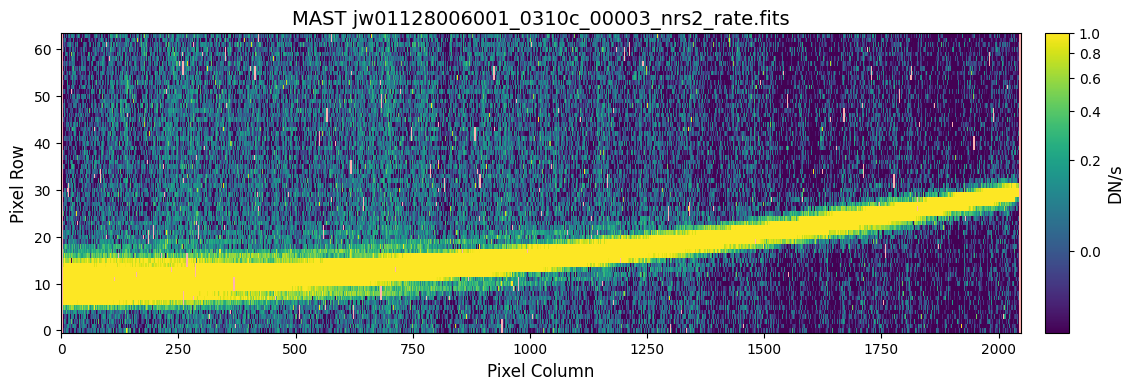

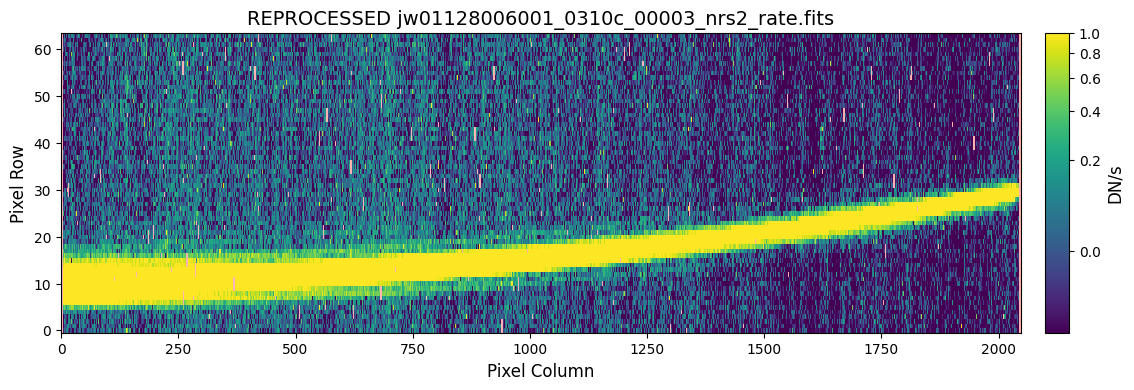

In [21]:
rate_file = rate_sci[-1]  # Show the last rate file, as an example.

# Compare to the data product in MAST
# generated using the pipeline with default parameters?
if compare_mast:
    # Download the MAST data product (or load it if you've downloaded it already).
    MAST_rate_file = get_jwst_file(os.path.basename(rate_file),
                                   save_directory=mast_products_dir)
    display_rate(MAST_rate_file, vmin=-0.1, vmax=1,
                 aspect=10, scale='asinh', title_prefix='MAST')  #, extname='dq')

display_rate(rate_file, vmin=-0.1, vmax=1,
             aspect=10, scale='asinh', title_prefix='REPROCESSED')  #, extname='dq')

[Link to Table of Contents](#Table-of-Contents)

---

## 6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)

In this section, we process our countrate (slope) image products from Stage 1 (`calwebb_detector1`) through the Spec2 (`calwebb_spec2`) pipeline to create Stage 2 data products.

* **Input**: A single countrate (slope) image (`_rate[ints].fits`) or an association file listing multiple inputs.
* **Output**: Calibrated products (rectified and unrectified) and 1D spectra.
	* `_cal[ints].fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
	* `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows). 
	* `_x1d[ints].fits`: Extracted 1D spectroscopic data (wavelength vs. flux).
      
The `Spec2Pipeline` applies additional instrumental corrections and calibrations (e.g., slit loss, path loss, etc.,) to countrate products that result in a fully calibrated individual exposure (per nod/dither position). The `Spec2Pipeline` also converts countrate products from units of DN/s to flux (Jy) for point sources and surface brightness (MJy/sr) for extended sources.

---

### 6.1 Configure `Spec2Pipeline`

The `Spec2Pipeline` has the following steps available for NIRSpec FS:

> * `assign_wcs`: Assigns wavelength solution for spectra.
> * `nsclean`: Cleans 1/f noise.
> * `bkg_subtract`: Performs image subtraction for background removal.
> * `extract_2d` : Extracts 2D arrays from spectral images.
> * `srctype`: Determines whether a spectroscopic source should be classified as a point or extended object.
> * `wavecorr` : Updates wavelength assignments for FS and MOS point sources that are offset in the dispersion direction within their slit.
> * `flat_field`: Applies flat-field corrections to the input science dataset.
> * `pathloss`: Calculates and applies corrections for signal loss in spectroscopic data.
> * `photom`: Applies photometric calibrations to convert data from countrate to surface brightness or flux density.
> * `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
> * `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Below, we set up a dictionary that defines how the `Spec2Pipeline` should be configured for FS data. 


<div class="alert alert-warning">

If pixel-to-pixel background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 

</div>

In [22]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# Boilerplate dictionary setup.
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['nsclean'] = {}, {}
spec2dict['extract_2d'], spec2dict['bkg_subtract'] = {}, {}
spec2dict['srctype'], spec2dict['wavecorr'] = {}, {}
spec2dict['flat_field'], spec2dict['pathloss'] = {}, {}
spec2dict['photom'], spec2dict['pixel_replace'] = {}, {}
spec2dict['resample_spec'], spec2dict['extract_1d'] = {}, {}

# Overrides for whether or not certain steps should be skipped (example).
spec2dict['bkg_subtract']['skip'] = not pixel_bg

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
# spec2dict['extract_1d']['override_extract1d'] = 'myfile.json'

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
# spec2dict['pixel_replace']['skip'] = False
# spec2dict['pixel_replace']['n_adjacent_cols'] = 5
# spec2dict['pixel_replace']['algorithm'] = 'fit_profile'

# Run nsclean for 1/f noise.
# spec2dict['nsclean']['skip'] = False
# spec2dict['nsclean']['n_sigma'] = 2

# Resample weight_type.
# spec2dict['resample_spec']['weight_type'] = 'exptime'

<div class="alert alert-info">
    
Resampling 2D spectra can sometimes introduce artificial noise and reduce the signal-to-noise ratio (SNR) in the resulting 1D spectra when using `weight_type='ivm'` ([known issue](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-fs-known-issues#NIRSpecFSKnownIssues-Resamplingof2-Dspectra:~:text=noise%20workaround%20notebook.-,Resampling%20of%202%2DD%20spectra,-Stages%202%20and)). The default is now set to 'exptime'. Consider the following when selecting a `weight_type`:
* **'ivm'**: Inverse variant scaling based on read noise (VAR_RNOISE), ideal for rejecting outliers and better suited for faint sources.
* **'exptime'**: Uses exposure time for scaling, improving SNR for bright sources.
</div>


<div class="alert alert-info">

JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. This 1/f noise appears as vertical banding that spans the entire width of the 2D spectrum and varies from column to column. The main pipeline algorithm for removing 1/f noise in NIRSpec data is called NSClean (Rauscher 2023), and it is not run by default. To correct for 1/f noise with `nsclean` in Stage 2, see the demo notebook for FS data [here](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/NIRSpec/NIRSpec_NSClean).

</div>

---

### 6.2 `Spec2Pipeline` ASN Files

[Association (ASN) files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) define the relationships between multiple exposures, allowing them to get processed as a set rather than individually. Processing an ASN file enables the exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

[Stage 2 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html) for FS data can include `science` and `background` exposure types. A Stage 2 ASN file requires at least one `science` file but can contain multiple `background` files that enable pixel-to-pixel background subtraction in `calwebb_spec2`.

This notebook downloads Stage 2 ASN files directly from MAST. However, the downloaded ASN files expect the input files to be in the same directory, which is incompatible with our directory structure. In the cell below, we update the `expname` fields in the ASN files to use absolute paths to ensure the pipeline looks in the correct locations.

<div class="alert alert-block alert-warning">

Background subtraction may not be correctly applied if more than *one* `science` file is included in the association. Additionally, pixel-to-pixel background subtraction will only be performed if the grating wheel has not moved between the target and off-scene associated background exposures. If the grating wheel moved between the target and background exposures (as would be the case if they were in different visits), pipeline processing will follow a more involved "master background" subtraction done in Stage 3.

</div>

In [23]:
# Get list of all spec2 ASN files and categorize them.
spec2_asn_all = glob.glob(f"{asn_dir}*spec2*asn.json")
candidate_asn = [asn for asn in spec2_asn_all if "-c" in asn]
obs_asn = [asn for asn in spec2_asn_all if "-o" in asn]

# Choose ASN files: candidate if available, otherwise observation ASN.
spec2_asn = candidate_asn or obs_asn
print(f"Stage 2 ASN Files:\n{'-'*20}\n" + "\n".join(spec2_asn))

Stage 2 ASN Files:
--------------------
./fs_data_01128/asn/jw01128-o006_20240815t163602_spec2_00009_asn.json
./fs_data_01128/asn/jw01128-o006_20240815t163602_spec2_00007_asn.json
./fs_data_01128/asn/jw01128-o006_20240815t163602_spec2_00008_asn.json


In [24]:
# Convert 'expname' paths in the ASN file to absolute paths.
# Ensures the pipeline can locate the files, regardless of the ASN file's location.
update_asn_paths(spec2_asn, exclude_dirs=[mast_products_dir])

jw01128-o006_20240815t163602_spec2_00009_asn.json 'expname' paths have been updated to absolute paths!
jw01128-o006_20240815t163602_spec2_00007_asn.json 'expname' paths have been updated to absolute paths!
jw01128-o006_20240815t163602_spec2_00008_asn.json 'expname' paths have been updated to absolute paths!


In [25]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
with open(spec2_asn[0], 'r') as f_obj:
    asnfile_data = json.load(f_obj)

JSON(asnfile_data, expanded=True)

<IPython.core.display.JSON object>

---

### 6.3 Run `Spec2Pipeline`

Run the science files and, if available, any background files through the `calwebb_spec2` pipeline using the `.call()` method

<div class="alert alert-block alert-warning">
Perform pixel-to-pixel background subtraction (if desired) here in Stage 2. Otherwise, reduce the backgrounds individually for master background subtraction in Stage 3 (if desired).
</div>

In [26]:
# To save runtime, make a new version of our spec2 parameter dictionary
# that turns off creation of quicklook 2d/1d spectra for science
# data.
spec2dict_sci = copy.deepcopy(spec2dict)
spec2dict_sci['resample_spec']['skip'] = False  # S2D products.
spec2dict_sci['extract_1d']['skip'] = False  # X1D products.

In [27]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.

start = time.time()

# Science files.
for asn in spec2_asn:

    asn_data = json.load(open(asn))
    sci_file = os.path.basename(asn_data['products'][0]['members'][0]['expname'])
    print(f"Applying Stage 2 Corrections & Calibrations to: {sci_file}")
    spec2sci_result = Spec2Pipeline.call(asn, save_results=True,
                                         steps=spec2dict_sci, output_dir=spec2_dir)

# Background files.
if master_bg:

    for rate in rate_bg:

        print(f"Applying Stage 2 Corrections & Calibrations to: "
              f"{os.path.basename(rate)}")
        spec2bg_result = Spec2Pipeline.call(rate, save_results=True,
                                            steps=spec2dict, output_dir=spec2_bgdir)

print(f"\nRun time: {round((time.time()-start)/60.0, 1)} min")
print("Hurray ... Stage 2 has been completed!\n")

Applying Stage 2 Corrections & Calibrations to: jw01128006001_0310c_00001_nrs1_rate.fits
Applying Stage 2 Corrections & Calibrations to: jw01128006001_0310c_00003_nrs1_rate.fits
Applying Stage 2 Corrections & Calibrations to: jw01128006001_0310c_00002_nrs1_rate.fits

Run time: 0.7 min
Hurray ... Stage 2 has been completed!



---

### 6.4 Display `Spec2Pipeline` Products

Inspect the Stage 2 calibrated spectra. If `compare_mast` is enabled, an additional plot will compare the reprocessed results with MAST products, which were processed using the default pipeline parameters. Reprocessing with a newer pipeline version may result in noticeable improvements in data quality.

In [28]:
# List the Stage 2 products.

# Science.
sci_cal = sorted(glob.glob(spec2_dir + '*_cal.fits'))
sci_s2d = sorted(glob.glob(spec2_dir + '*_s2d.fits'))
sci_x1d = sorted(glob.glob(spec2_dir + '*_x1d.fits'))

print(f"SCIENCE | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(sci_cal))
print(f"SCIENCE | Stage 2 S2D Products:\n{'-'*20}\n" + "\n".join(sci_s2d))
print(f"SCIENCE | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(sci_x1d))

# Background.
bg_cal = sorted(glob.glob(spec2_bgdir + '*_cal.fits'))
bg_s2d = sorted(glob.glob(spec2_bgdir + '*_s2d.fits'))
bg_x1d = sorted(glob.glob(spec2_bgdir + '*_x1d.fits'))

print(f"BACKGROUND | Stage 2 CAL Products:\n{'-'*20}\n" + "\n".join(bg_cal))
print(f"BACKGROUND | Stage 2 S2D Products:\n{'-'*20}\n" + "\n".join(bg_s2d))
print(f"BACKGROUND | Stage 2 X1D Products:\n{'-'*20}\n" + "\n".join(bg_x1d))

SCIENCE | Stage 2 CAL Products:
--------------------
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_cal.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_cal.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_cal.fits
SCIENCE | Stage 2 S2D Products:
--------------------
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_s2d.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_s2d.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_s2d.fits
SCIENCE | Stage 2 X1D Products:
--------------------
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_x1d.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_x1d.fits
./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_x1d.fits
BACKGROUND | Stage 2 CAL Products:
--------------------

BACKGROUND | Stage 2 S2D Products:
--------------------

BACKGROUND | Stage 2 X1D Products:
--------------------



['./fs_data_01128/mast_products/jw01128006001_0310c_00001_nrs1_x1d.fits', './fs_data_01128/mast_products/jw01128006001_0310c_00002_nrs1_x1d.fits', './fs_data_01128/mast_products/jw01128006001_0310c_00003_nrs1_x1d.fits']
None
None
['./fs_data_01128/mast_products/jw01128006001_0310c_00001_nrs1_x1d.fits', './fs_data_01128/mast_products/jw01128006001_0310c_00002_nrs1_x1d.fits', './fs_data_01128/mast_products/jw01128006001_0310c_00003_nrs1_x1d.fits']
None
None
['./fs_data_01128/mast_products/jw01128006001_0310c_00001_nrs1_x1d.fits', './fs_data_01128/mast_products/jw01128006001_0310c_00002_nrs1_x1d.fits', './fs_data_01128/mast_products/jw01128006001_0310c_00003_nrs1_x1d.fits']
None
None
['./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_x1d.fits', './fs_data_01128/Obs006/stage2/jw01128006001_0310c_00002_nrs1_x1d.fits', './fs_data_01128/Obs006/stage2/jw01128006001_0310c_00003_nrs1_x1d.fits']
None
None
['./fs_data_01128/Obs006/stage2/jw01128006001_0310c_00001_nrs1_x1d.fits', './fs_

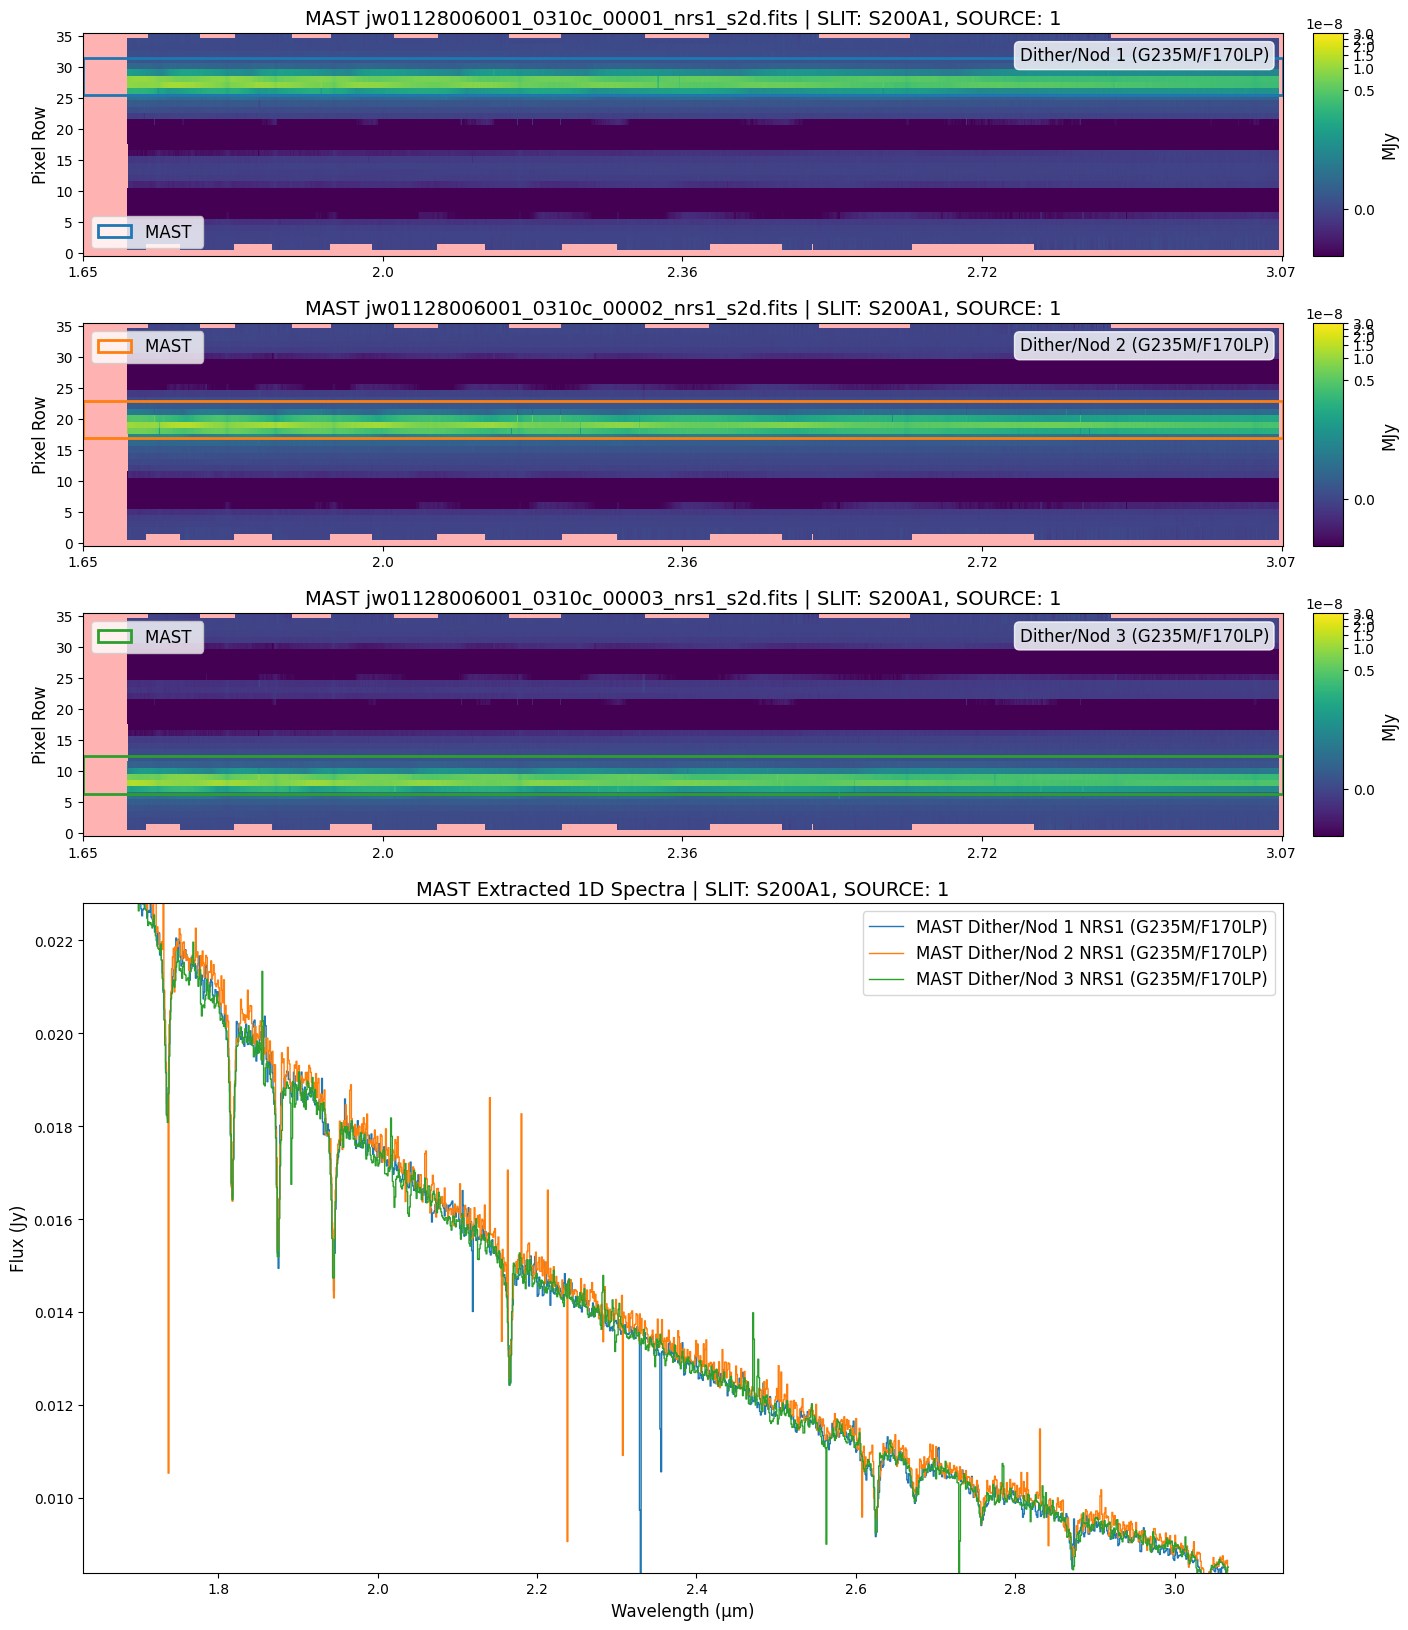

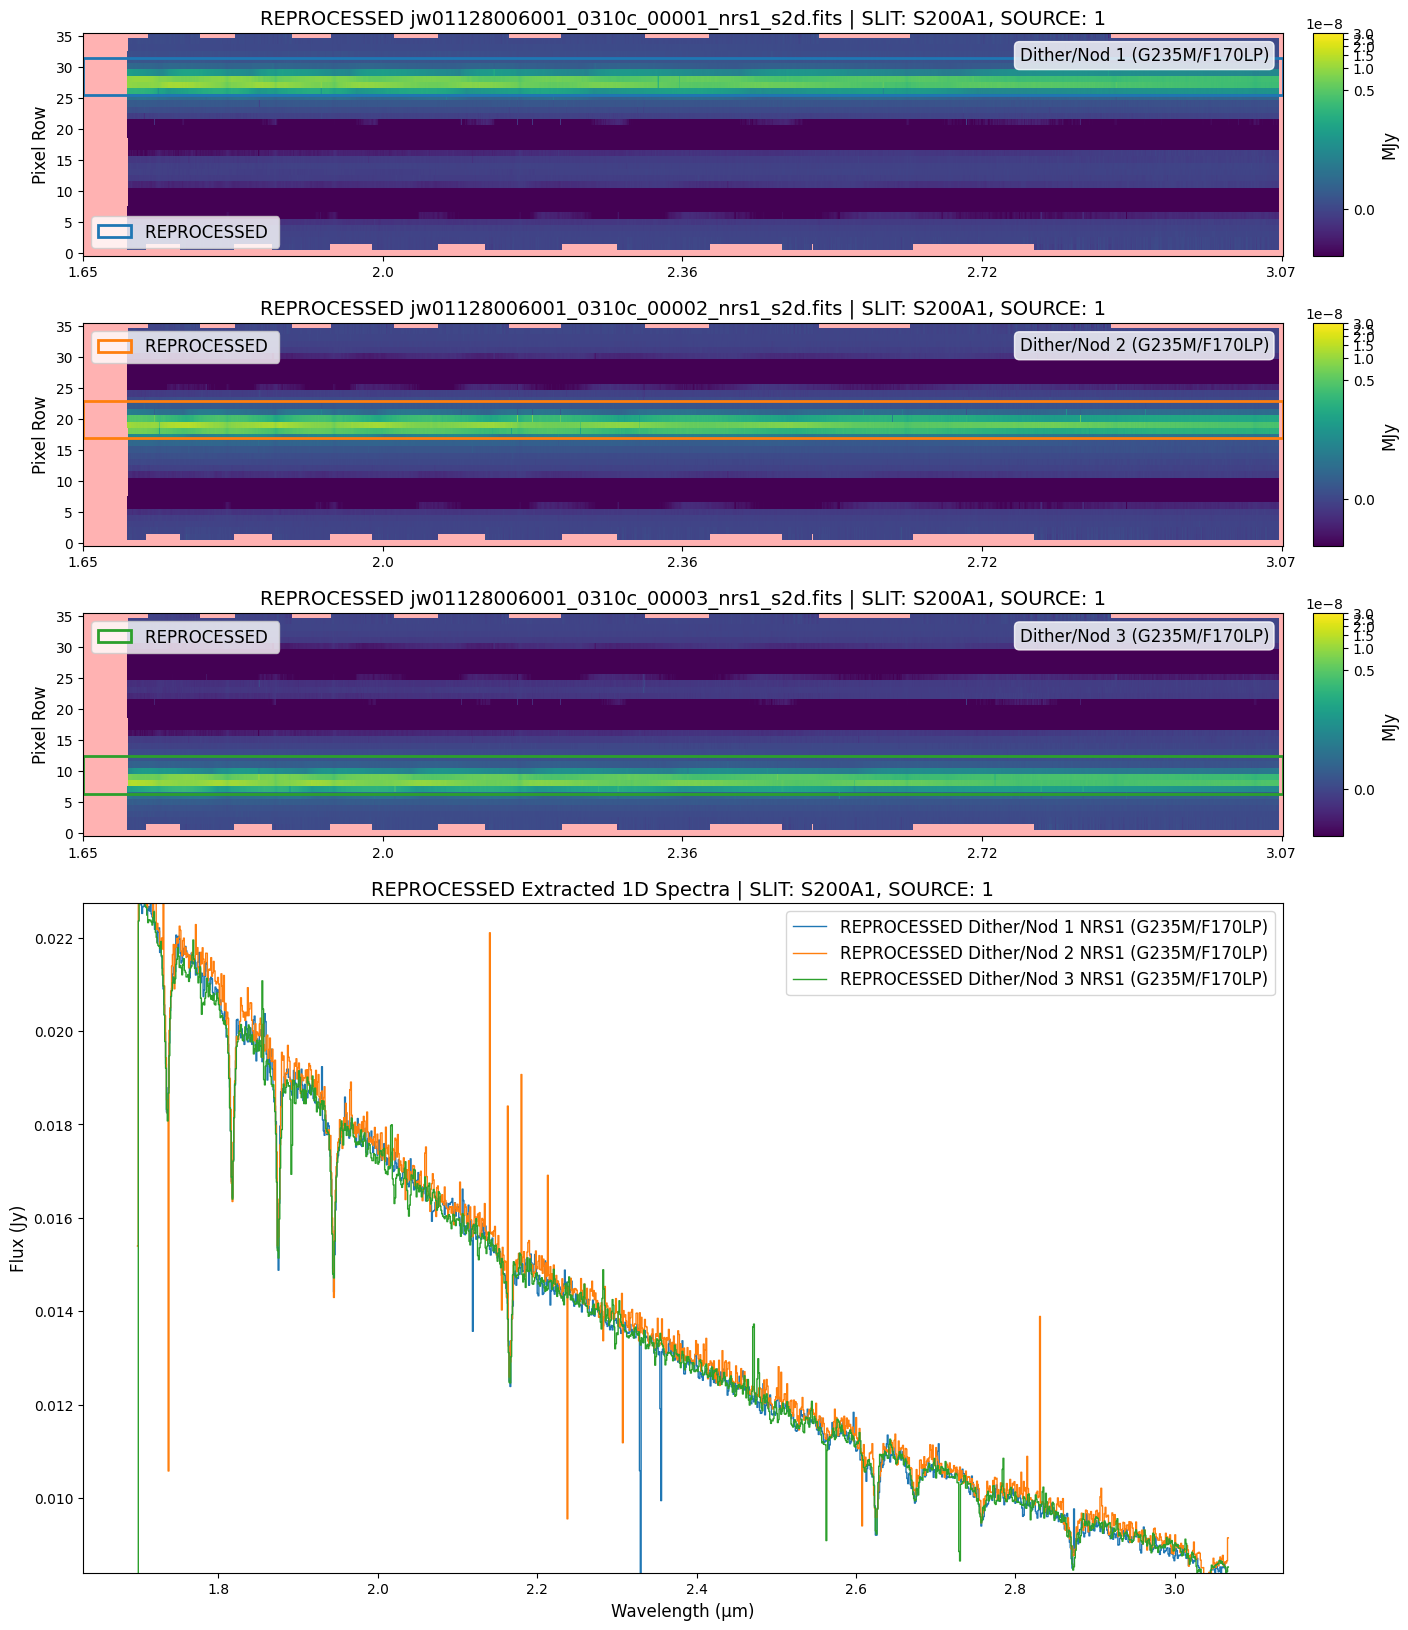

In [29]:
if compare_mast:
    MAST_s2ds = []
    MAST_x1ds = []
    for s2d, x1d in zip(sci_s2d, sci_x1d):
        # Download the MAST data product (or load it if you've downloaded it already).
        MAST_s2d = get_jwst_file(os.path.basename(s2d),
                                 save_directory=mast_products_dir)
        MAST_x1d = get_jwst_file(os.path.basename(x1d),
                                 save_directory=mast_products_dir)
        MAST_s2ds.append(MAST_s2d)
        MAST_x1ds.append(MAST_x1d)
    display_spectra(MAST_s2ds+MAST_x1ds, source_id='S200A1',
                    scale='log', vmin=-0.1e-9, vmax=3e-8, title_prefix='MAST')

display_spectra(sci_s2d+sci_x1d, source_id='S200A1',
                scale='log', vmin=-0.1e-9, vmax=3e-8, title_prefix='REPROCESSED')

[Link to Table of Contents](#Table-of-Contents)

---

## 7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)

In this section, we process our calibrated spectra from Stage 2 (`calwebb_spec2`) through the Spec3 (`calwebb_spec3`) pipeline to create Stage 3 data products.

* **Input**: An ASN file that lists multiple calibrated exposures (`_cal.fits`) in addition to any background exposures (`_x1d.fits`).
* **Output**: A single calibrated product (rectified and unrectified) and 1D spectrum. These data products have units of MJy/sr (or Jy for extracted point-source spectra).
	* `_cal.fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
    * `_crf.fits`: Calibrated 2D (unrectified) spectra whose DQ array has been updated to flag pixels detected as outliers (ncols x nrows).
    * `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows). 
	* `_x1d.fits`: Extracted 1D spectroscopic data.      

The `Spec3Pipeline` performs additional corrections (e.g., outlier detection, background subtraction) and combines calibrated data from multiple exposures (e.g. a dither/nod pattern) into a single 2D spectral product, as well as a combined 1D spectrum.

---

### 7.1 Configure `Spec3Pipeline`

The `Spec3Pipeline` has the following steps available for NIRSpec FS:

> * `assign_mtwcs`: Modifies the WCS output frame in each exposure of a Moving Target (MT) observation association.
> * `master_background`: Master background subtraction.
> * `outlier_detection` : Identification of bad pixels or cosmic-rays that remain in each of the input images.
> * `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
> * `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)

Below, we set up a dictionary that defines how the `Spec3Pipeline` should be configured for FS data. 


<div class="alert alert-warning">

If master background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below. 

</div>

In [30]:
# Set up a dictionary to define how the Spec3 pipeline should be configured.

# Boilerplate dictionary setup.
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['master_background'], spec3dict['outlier_detection'] = {}, {}, {}
spec3dict['pixel_replace'], spec3dict['resample_spec'], spec3dict['extract_1d'] = {}, {}, {}

# Overrides for whether or not certain steps should be skipped (example).
spec3dict['outlier_detection']['skip'] = True

# Master background usage was set up above, propagate that here.
spec3dict['master_background']['skip'] = not master_bg

# Overrides for various reference files
# Files should be in the base local directory or provide full path
# spec3dict['extract_1d']['override_extract1d'] = 'myfile.json'  # Spectral extraction parameters (JSON file).

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
# spec3dict['pixel_replace']['skip'] = False
# spec3dict['pixel_replace']['n_adjacent_cols'] = 5
# spec3dict['pixel_replace']['algorithm'] = 'fit_profile'

# Resample weight_type.
# spec3dict['resample_spec']['weight_type'] = 'exptime'

<div class="alert alert-block alert-info">
    
The outlier detection step can be too aggressive for FS data, and better results may be obtained by turning it off.
</div>

---

### 7.2 Create `Spec3Pipeline` ASN Files

[Stage 3 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_technical.html) for FS data can include `science` and `background` exposure types. A Stage 3 ASN file requires at least one `science` file (there is usually more than one) but can contain multiple `background` files that enable master background subtraction in `calwebb_spec3`. **Note that the science exposures should be in the `_cal.fits` format, while the background exposures must be in the `_x1d.fits` format.**

This notebook downloads Stage 3 ASN files directly from MAST. However, the downloaded ASN files expect the input files to be in the same directory, which is incompatible with our directory structure. In the cell below, we update the expname fields in the ASN files to use absolute paths to ensure the pipeline looks in the correct locations.

In [31]:
# Get list of ALL spec2 ASN files.
spec3_asn = glob.glob(f"{asn_dir}*spec3*asn.json")
print(f"Stage 3 ASN Files:\n{'-'*20}\n" + "\n".join(spec3_asn))

Stage 3 ASN Files:
--------------------
./fs_data_01128/asn/jw01128-o006_20240815t163602_spec3_00003_asn.json


In [32]:
# Convert 'expname' paths in the ASN file to absolute paths
# Ensures the pipeline can locate the files, regardless of the ASN file's location.
update_asn_paths(spec3_asn, exclude_dirs=[mast_products_dir])

jw01128-o006_20240815t163602_spec3_00003_asn.json 'expname' paths have been updated to absolute paths!


In [33]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
with open(spec3_asn[0], 'r') as f_obj:
    asnfile_data = json.load(f_obj)

JSON(asnfile_data, expanded=True)

<IPython.core.display.JSON object>

---



### 7.3 Run `Spec3Pipeline`

Run the science files and, if available, any background files through the `calwebb_spec3` pipeline using the `.call()` method.

In [34]:
# Run Stage 3 pipeline using the custom spec3dict dictionary.

start = time.time()
    
for spec3_asn in glob.glob(asn_dir + '*spec3*asn.json'):

    print(f"Applying Stage 3 Corrections & Calibrations to: {os.path.basename(spec3_asn)}")
    spec3_result = Spec3Pipeline.call(spec3_asn, save_results=True, steps=spec3dict, output_dir=spec3_dir) 

print(f"\nRun time: {round((time.time()-start)/60.0, 1)} min")
print("Hurray ... Stage 3 has been completed!\n")

Applying Stage 3 Corrections & Calibrations to: jw01128-o006_20240815t163602_spec3_00003_asn.json

Run time: 0.3 min
Hurray ... Stage 3 has been completed!



---

### 7.4 Display `Spec3Pipeline` Products

Inspect the Stage 3 combined calibrated spectra. If `compare_mast` is enabled, an additional plot will compare the reprocessed results with MAST products, which were processed using the default pipeline parameters. Reprocessing with a newer pipeline version may result in noticeable improvements in data quality.

In [35]:
# List the Stage 3 products.

stage3_cal = sorted(glob.glob(spec3_dir + '*_cal.fits'))
stage3_s2d = sorted(glob.glob(spec3_dir + '*_s2d.fits'))
stage3_x1d = sorted(glob.glob(spec3_dir + '*_x1d.fits'))

print(f"Stage 3 CAL Products:\n{'-'*20}\n" + "\n".join(stage3_cal))
print(f"Stage 3 S3D Products:\n{'-'*20}\n" + "\n".join(stage3_s2d))
print(f"Stage 3 X1D Products:\n{'-'*20}\n" + "\n".join(stage3_x1d))


Stage 3 CAL Products:
--------------------
./fs_data_01128/Obs006/stage3/jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_cal.fits
Stage 3 S3D Products:
--------------------
./fs_data_01128/Obs006/stage3/jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_s2d.fits
Stage 3 X1D Products:
--------------------
./fs_data_01128/Obs006/stage3/jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_x1d.fits


['./fs_data_01128/Obs006/stage3/jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_x1d.fits']
None
None


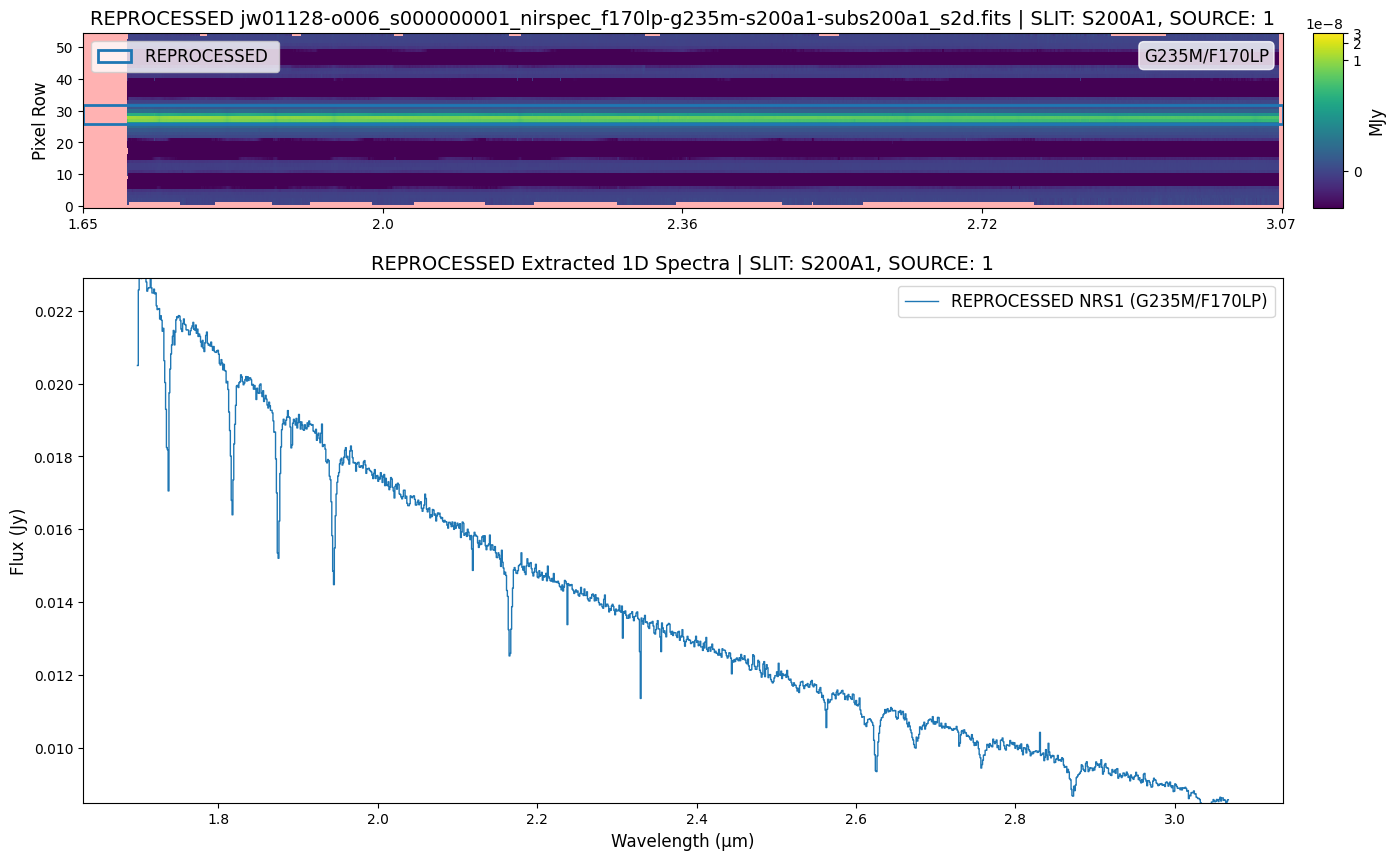

In [36]:
if compare_mast:
    MAST_stage3_s2ds = []
    MAST_stage3_x1ds = []
    for s2d, x1d in zip(stage3_s2d, stage3_x1d):
        # Download the MAST data product (or load it if you've downloaded it already).
        # Convert to old naming format to download from MAST.
        s2d_file = os.path.basename(s2d).replace('s0000000', 's000')
        x1d_file = os.path.basename(x1d).replace('s0000000', 's000')
        #MAST_stage3_s2d = get_jwst_file(s2d_file, save_directory=mast_products_dir)
        #MAST_stage3_x1d = get_jwst_file(x1d_file, save_directory=mast_products_dir)
        #MAST_stage3_s2ds.append(MAST_stage3_s2d)
        #MAST_stage3_x1ds.append(MAST_stage3_x1d)
    #display_spectra(MAST_stage3_s2ds+MAST_stage3_x1ds, source_id='S200A1', scale='log', vmin=-0.1e-9, vmax=3e-8, title_prefix='MAST')

display_spectra(stage3_s2d+stage3_x1d, source_id='S200A1', scale='log', is_stage3=True,
                vmin=-0.1e-9, vmax=3e-8, title_prefix='REPROCESSED', source_type='POINT')

[Link to Table of Contents](#Table-of-Contents)

---

## 8. Modifying the EXTRACT1D Reference File (as needed)

The `extract_1d` step's `use_source_pos` parameter in Stage 2 generally centers the 1D extraction box on the actual source location effectively and thus doesn't usually require manual adjustment. However, in some cases, adjusting the position of the extraction box by modifying the EXTRACT1D reference file may be useful. The following section demonstrates how to do this.

The EXTRACT1D reference file, along with several other parameter files, can be found in the `CRDS_PATH` directory. While some files, like `.json` files, can be manually edited, we modify them using Python.


<div class="alert alert-block alert-danger">
    
**Warning**: Currently, there is no aperture correction in place for NIRSpec, so the `extract_width` parameter **MUST** remain unchanged (6 pixels wide; 5 for S1600A1) to ensure proper flux calibration! The extraction box limits (`ystart` and `ystop`) can be modified; however, if `ystart` and `ystop` do not match the `extract_width`, the `extract_width` takes precedence and is applied symmetrically around the midpoint between `ystart` and `ystop`.

</div>


In [37]:
# Modify the EXTRACT1D reference file.

# If you don't know the reference file name this should work.
# extract_1d_ref = Spec3Pipeline().get_reference_file(stage3_s2d, 'extract1d')

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0008.json'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0008.json']

# Open EXTRACT1D reference file in read-mode.
with open(extract_1d_ref, "r") as ref_file:
    params = json.load(ref_file)

    yshift = -4  # Applied shift in pixels as example.
    
    # S200A1
    params["apertures"][0]["extract_width"] = 6  # Extraction aperture radius in pixels, can be modified.
    params["apertures"][0]["ystart"] += yshift
    params["apertures"][0]["ystop"] += yshift

    # S200B1
    params["apertures"][1]["extract_width"] = 6  # Extraction aperture radius in pixels, can be modified.
    params["apertures"][1]["ystart"] = 26.5
    params["apertures"][1]["ystop"] = 31.5
    
    # S200A2
    params["apertures"][2]["extract_width"] = 6  # Extraction aperture radius in pixels, can be modified.
    params["apertures"][2]["ystart"] = 26.5
    params["apertures"][2]["ystop"] = 31.5
    
    # S400A1
    params["apertures"][3]["extract_width"] = 6  # Extraction aperture radius in pixels, can be modified.
    params["apertures"][3]["ystart"] = 31
    params["apertures"][3]["ystop"] = 36
    
    # S1600A1
    params["apertures"][4]["extract_width"] = 5  # Extraction aperture radius in pixels, can be modified.
    params["apertures"][4]["ystart"] = 14
    params["apertures"][4]["ystop"] = 18
    
# Write changes to a new file.
newData = json.dumps(params, indent=4)
# Add the suffix '_fs' to distinguish the file from the default version.
extract_1d_ref_mod = basedir+os.path.basename(extract_1d_ref)[:-5] + "_fs.json"
with open(extract_1d_ref_mod, "w") as file:
    file.write(newData)

In [38]:
# Inspect the EXTRACT1D reference file.
with open(extract_1d_ref_mod, 'r') as f_obj:
    extract_1d_ref_mod_data = json.load(f_obj)

JSON(extract_1d_ref_mod_data, expanded=True)

<IPython.core.display.JSON object>

Now, we re-extract the 1D spectrum by running the `Extract1dStep` and overriding the reference file.


In [42]:
from jwst.extract_1d import Extract1dStep  # Extract1D Individual Step

Extract1dStep.call(stage3_s2d, 
                   save_results=True, 
                   output_dir=spec3_dir, 
                   output_use_model=True,
                   suffix='x1d_mod',  # Change suffix to easily find modified file.
                   use_source_posn=False, 
                   override_extract1d=extract_1d_ref_mod)

<MultiSpecModel from jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_x1d_mod.fits>

We now plot again the 2D/1D rectified spectrum and showing the original extraction box in red and the new extraction box in black.


['./fs_data_01128/Obs006/stage3/jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_x1d.fits']
['./fs_data_01128/Obs006/stage3/jw01128-o006_s000000001_nirspec_f170lp-g235m-s200a1-subs200a1_x1d_mod.fits']
None


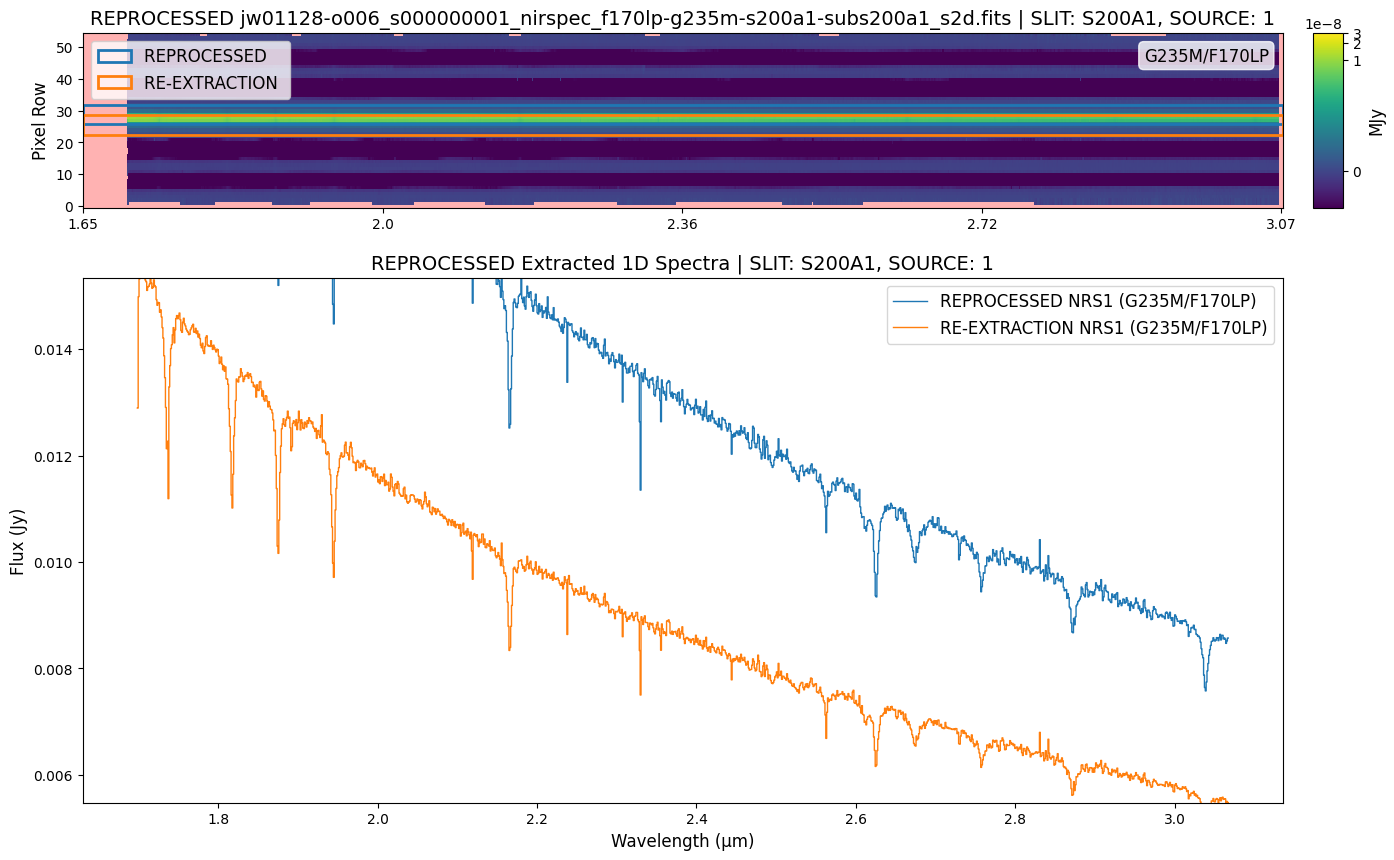

In [46]:
stage3_x1ds_mod = sorted(glob.glob(spec3_dir + '*_x1d_mod.fits'))
display_spectra(stage3_s2d+stage3_x1d, compare_x1d=stage3_x1ds_mod, is_stage3=True,
                source_id='S200A1', scale='log', vmin=-0.1e-9, vmax=3e-8, title_prefix='REPROCESSED')

As expected, the spectrum extracted in the shifted location has lower flux that the spectrum extracted in the center of the 2D spectral trace. 

---

<figure>
       <img src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo\" align="right" style="width: 200px"/>
</figure>
   
[Top of Page](#NIRSpec-FS-Pipeline-Notebook)